<a href="https://colab.research.google.com/github/JamesAttwood1910/Diplomado_USACH/blob/main/JamesAttwoodEntregaFinal_TallerProyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1) Datos y Librerías

In [ ]:
# Librerías bascias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Librerías para crear, y evaluar modelos

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix 
from sklearn import metrics 
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [ ]:
# Importacion de los datos

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
PdM_final_final_target = pd.read_csv('/content/drive/MyDrive/TallerProyecto/PdM_final_final_target.csv')

### 2) Modelamiento

**Selección de algoritmos**

A continuación se entrenarán cuatro modelos de classificación. 

- Decision Tree
- Random Forest
- Decision Tree Bagging
- XGBoost

Cada modelo se entrenará tres veces: 

- La primera vez para predecir si una falla va a pasar con un periodo de anticipación de **tres horas**. 
- La segunda vez para predecir si una falla va a pasar con un periodo de anticipación de **sies horas**.
- La tercera vez para predecir si una falla va a pasar con un periodo de anticipación de **doce horas**.

El modelo **Decision Tree** se ha elegido ya que es rapido para entrenar y puede dar una idea rapidamente del poder predictivo de los datos. 

**Random Forest** y **Decison Tree Bagging** se han elegido ya que pueden reducir el sobreajuste que un modelo Decision Tree pueda experimentar. Tambien Random Forest da la opción de extraer cuales variables tienen mas importancia en el modelo. 

Parecidamente **XGBoost** se ha elegido ya que los variables con mas importancia en el modelo se pueden extraer. Tambien, a differencia de los otros modelos elegidos, da un porcentaje para cada predicción y por tanto su umbral de decision puede ser optimizado. 



#### 2.1) Preparación de datos

A continuación las siguientes variables se removerán de la base de datos por las razones comentadas: 

- Unnamed: 0 (variable creada al cargar la base de datos) 
- failure_binomial (se ha remplazado como la variable dependiente por 3_hours, 6_hours, 12_hours)
- date (se ha remplzado por variables unicas para año, mes, dia de la semana, y hora)
- model_age (nueva variable creada para edad escalada)
- new_index (el numero de identifiación para cada registro en la base de datos) 
- hours_to_failure (variable utilizada en la creación de las variables dependientes, no se requiere en etapa de entrenamiento). 

Tambien los valores faltantes en las variables de dias desde ultimo mantenimiento y error cuando el primer mantenimiento o error no hubiera pasado se remplazarán con un valor de 0. 

In [ ]:
data = PdM_final_final_target 

In [ ]:
del data['Unnamed: 0']

In [ ]:
data.head()

,new_index,machineID,date,volt,rotate,pressure,vibration,model_age,year,month,weekday,hour,model_age_scaled,failure_binomial,errorID_error1,errorID_error2,errorID_error3,errorID_error4,errorID_error5,maintenance_comp1,maintenance_comp2,maintenance_comp3,maintenance_comp4,volt_media_3_horas,rotate_media_3_horas,pressure_media_3_horas,vibration_media_3_horas,volt_max_3_horas,rotate_max_3_horas,pressure_max_3_horas,vibration_max_3_horas,volt_min_3_horas,rotate_min_3_horas,pressure_min_3_horas,vibration_min_3_horas,volt_std_3_horas,rotate_std_3_horas,pressure_std_3_horas,vibration_std_3_horas,volt_media_6_horas,...,rotate_max_6_horas,pressure_max_6_horas,vibration_max_6_horas,volt_min_6_horas,rotate_min_6_horas,pressure_min_6_horas,vibration_min_6_horas,volt_std_6_horas,rotate_std_6_horas,pressure_std_6_horas,vibration_std_6_horas,volt_media_12_horas,rotate_media_12_horas,pressure_media_12_horas,vibration_media_12_horas,volt_max_12_horas,rotate_max_12_horas,pressure_max_12_horas,vibration_max_12_horas,volt_min_12_horas,rotate_min_12_horas,pressure_min_12_horas,vibration_min_12_horas,volt_std_12_horas,rotate_std_12_horas,pressure_std_12_horas,vibration_std_12_horas,days_since_last_errorID_error1,days_since_last_errorID_error2,days_since_last_errorID_error3,days_since_last_errorID_error4,days_since_last_errorID_error5,days_since_last_maintenance_comp1,days_since_last_maintenance_comp2,days_since_last_maintenance_comp3,days_since_last_maintenance_comp4,hours_to_failure,3_hours,6_hours,12_hours
0,1,1,2015-01-01 06:00:00,0.499928,0.503194,0.459050,0.487945,18.0,2015,1,3,6,1.144519,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.0,0,0,0
1,2,1,2015-01-01 07:00:00,0.415395,0.474884,0.328274,0.460912,18.0,2015,1,3,7,1.144519,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.0,0,0,0
2,3,1,2015-01-01 08:00:00,0.466796,0.698752,0.178160,0.311752,18.0,2015,1,3,8,1.144519,0,0,0,0,0,0,0,0,0,0,0.460706,0.558943,0.321828,0.420203,0.499928,0.698752,0.459050,0.487945,0.415395,0.474884,0.17816,0.311752,0.042594,0.121903,0.140556,0.094889,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,0,0,0
3,4,1,2015-01-01 09:00:00,0.412756,0.373197,0.430624,0.423896,18.0,2015,1,3,9,1.144519,0,0,0,0,0,0,0,0,0,0,0.431649,0.515611,0.312353,0.398853,0.466796,0.698752,0.430624,0.460912,0.412756,0.373197,0.17816,0.311752,0.030467,0.166555,0.126983,0.077670,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.0,0,0,0
4,5,1,2015-01-01 10:00:00,0.382001,0.533508,0.450207,0.179498,18.0,2015,1,3,10,1.144519,0,0,0,0,0,0,0,0,0,0,0.420518,0.535152,0.352997,0.305049,0.466796,0.698752,0.450207,0.423896,0.382001,0.373197,0.17816,0.179498,0.042927,0.162784,0.151729,0.122337,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.0,0,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876100 entries, 0 to 876099
Data columns (total 84 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   new_index                          876100 non-null  int64  
 1   machineID                          876100 non-null  int64  
 2   date                               876100 non-null  object 
 3   volt                               876100 non-null  float64
 4   rotate                             876100 non-null  float64
 5   pressure                           876100 non-null  float64
 6   vibration                          876100 non-null  float64
 7   model_age                          876100 non-null  float64
 8   year                               876100 non-null  int64  
 9   month                              876100 non-null  int64  
 10  weekday                            876100 non-null  int64  
 11  hour                               8761

In [ ]:
data_sub = data.drop(['failure_binomial','date', 'model_age', 'new_index', 'hours_to_failure'], axis=1)

In [ ]:
data_sub = data_sub.fillna(0)

#### 2.2) Creación de train, validation, y test

Ahora se crearán las bases de datos de train, validation, y test. La base de train se utilizará para entrenar el modelo. La base de validation se utilizará para evaluar que tan bien cada modelo se ajuste a los datos. Tras evaluar cada modelo un modelo final se elegirá y será probado con la base de datos de test. 

La base de datos contiene registros de 100 máquinas diferentes. No desea dividir los registros de una máquina en los tres grupos de train, validación y tes. Por lo tanto, cada máquina se asignará aleatoriamente a uno de los grupos de train, validación o test con todas sus observaciones incluidas en el grupo elegido. 

In [ ]:
pd_id = data_sub['machineID'].unique()

In [ ]:
pd_id

array([  1,  10, 100,  11,  12,  13,  14,  15,  16,  17,  18,  19,   2,
        20,  21,  22,  23,  24,  25,  26,  27,  28,  29,   3,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,   4,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,   5,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,   6,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,   7,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         8,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,   9,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99])

In [ ]:
pd_id = pd.DataFrame(pd_id)

In [ ]:
pd_id.rename(columns={0: "MachineID"}, inplace = True)

In [ ]:
np.random.seed(42)
pd_id['probabilidad'] = (np.random.randint(0, 10000, pd_id.shape[0]))/10000
pd_id=pd_id[['MachineID', 'probabilidad']]

In [ ]:
pd_id

,MachineID,probabilidad
0,1,0.7270
1,10,0.0860
2,100,0.5390
3,11,0.5191
4,12,0.5734
...,...,...
95,95,0.6736
96,96,0.0391
97,97,0.5892
98,98,0.3561


In [ ]:
pd_id['GROUPO'] = np.where(((pd_id.probabilidad <= 0.50)), 'TRAINING', 
                                   np.where(((pd_id.probabilidad <= 0.75)), 'VALIDATION', 
                                            'TESTING'))

In [ ]:
pd_id

,MachineID,probabilidad,GROUPO
0,1,0.7270,VALIDATION
1,10,0.0860,TRAINING
2,100,0.5390,VALIDATION
3,11,0.5191,VALIDATION
4,12,0.5734,VALIDATION
...,...,...,...
95,95,0.6736,VALIDATION
96,96,0.0391,TRAINING
97,97,0.5892,VALIDATION
98,98,0.3561,TRAINING


In [ ]:
pd_id.groupby(['GROUPO'])['probabilidad'].count()

GROUPO
TESTING       28
TRAINING      43
VALIDATION    29
Name: probabilidad, dtype: int64

In [ ]:
data_sub.rename(columns={'machineID': "MachineID"}, inplace = True)

In [ ]:
data_sub = data_sub.merge(pd_id, on=['MachineID'], how = 'left')

In [ ]:
training = data_sub[data_sub['GROUPO'] == 'TRAINING']

In [ ]:
validation = data_sub[data_sub['GROUPO'] == 'VALIDATION']

In [ ]:
testing = data_sub[data_sub['GROUPO'] == 'TESTING']

In [ ]:
training.drop(['GROUPO','probabilidad'], axis = 1, inplace = True)

In [ ]:
testing.drop(['GROUPO','probabilidad'], axis = 1, inplace = True)

In [ ]:
validation.drop(['GROUPO','probabilidad'], axis = 1, inplace = True)

In [ ]:
X_training = training.drop(['3_hours', '6_hours', '12_hours', 'MachineID'], axis =1)

In [ ]:
Y1 = training['3_hours']
Y2 = training['6_hours']
Y3 = training['12_hours']

In [ ]:
X_validation = validation.drop(['3_hours', '6_hours', '12_hours', 'MachineID'], axis =1)

In [ ]:
Y1_val = validation['3_hours']
Y2_val = validation['6_hours']
Y3_val = validation['12_hours']

In [ ]:
X_testing = testing.drop(['3_hours', '6_hours', '12_hours', 'MachineID'], axis =1)

In [ ]:
Y1_test = testing['3_hours']
Y2_test = testing['6_hours']
Y3_test = testing['12_hours']

### 3) Metrica de evaluación

Este prjecto se trata de la creación de un moelo de classificación. Por lo tanto, las metricas de evaluación que se utilizarán son: 

- Recall
- Pecision

Recall mostrará que tan bien los modelos reducen la cantidad de falsos negativos. 

Precision expondrá que tan bien los modelos reducen la cantidad de falsos positivos. 

En el contexto del problema de negocio se priorizará la reduccion en falsos negativos (aumento en Recall) ya que se refieren a cuando el modelo predice que no habrá una falla, pero en realidad sí la maquina fallará. Hablando economicamente un Falso Positivo (aumento en Precision) es mejor ya que solo resultará en mantención de la maquina cuando no era completamente necesaria. 

La metrica de accuracy no no será muy valorada ya que los datos están desequilibrados con muchos más registros de las maquinas funcionado sin una falla y, por lo tanto, será fácil obtener un resultado de alto accuracy con todos los registros clasificados como no tener una falla. 

A continuación una función se creará para evaluar cada modelo. 


In [ ]:
def evaluacion(modelo = None, umbral = 0.5, y_val_real = None):
    print('Resltados de ' +str(modelo)+' con umbral de decision de ' +str(umbral))
    print()
    y_val_real_ = validation[y_val_real]
    y_val_pred = modelo.predict(X_validation)
    print(classification_report(y_val_real_, y_val_pred))
    print()
    print('Recall: ', recall_score(y_val_real_, y_val_pred, average='binary'))
    print()
    print('Precision: ', precision_score(y_val_real_, y_val_pred, average='binary'))
    print()
    print('F1: ',f1_score(y_val_real_, y_val_pred, average='binary'))
    print()
    print('Accuracy: ', accuracy_score(y_val_real_, y_val_pred))
    print()
    print('Confusion Matrix')
    plt.figure(figsize=(10,10))
    sns.heatmap(confusion_matrix(y_val_real_, y_val_pred), annot=True, fmt = 'g')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()


### 4) Diseño y Aplicación

En esta sección se entrenarán los modelos utilizando los datos de train. 

#### 4.1) Decision Tree

##### DT - Tres Horas de Anticipación

In [ ]:
# DT Classifier para 3 horas de anticipacion

In [ ]:
from sklearn.tree import DecisionTreeClassifier
DTclf = DecisionTreeClassifier()
DTclf.fit(X_training, Y1)

DecisionTreeClassifier()

Resltados de DecisionTreeClassifier() con umbral de decision de 0.5

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    253221
           1       0.86      0.84      0.85       848

    accuracy                           1.00    254069
   macro avg       0.93      0.92      0.93    254069
weighted avg       1.00      1.00      1.00    254069


Recall:  0.8419811320754716

Precision:  0.8612786489746683

F1:  0.8515205724508049

Accuracy:  0.9990199512730794

Confusion Matrix


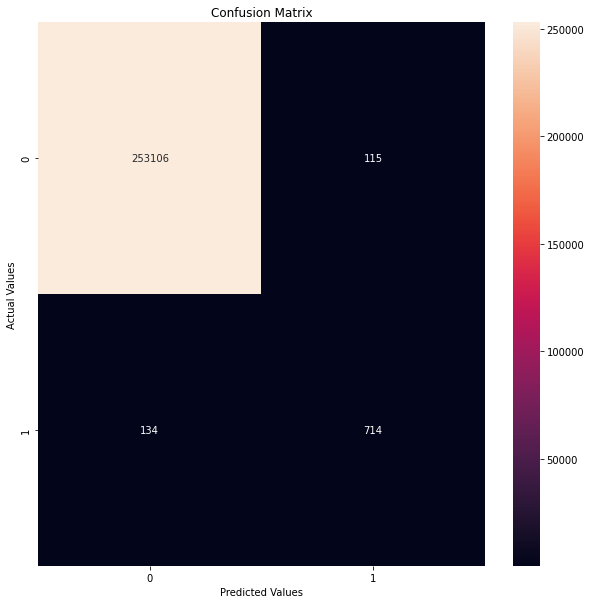

In [ ]:
evaluacion(modelo = DTclf, y_val_real = '3_hours')

**Commentarios**

Este modelo logra predecir 714 de 848 de las fallas con un tiempo de anticipación de 3 horas, dando un recall de 0.842. Tambien el modelo tuvo exito en la reduccion de falsos positivos. 

##### DT - Sies Horas de Anticipación

In [ ]:
# DT Classifier para 6 horas de anticipacion

In [ ]:
from sklearn.tree import DecisionTreeClassifier
DTclf_Y2 = DecisionTreeClassifier(random_state=123)
DTclf_Y2.fit(X_training, Y2)

DecisionTreeClassifier(random_state=123)

Resltados de DecisionTreeClassifier(random_state=123) con umbral de decision de 0.5

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    252585
           1       0.89      0.86      0.87      1484

    accuracy                           1.00    254069
   macro avg       0.94      0.93      0.94    254069
weighted avg       1.00      1.00      1.00    254069


Recall:  0.8578167115902965

Precision:  0.8858733472512178

F1:  0.8716193084560082

Accuracy:  0.9985240230016256

Confusion Matrix


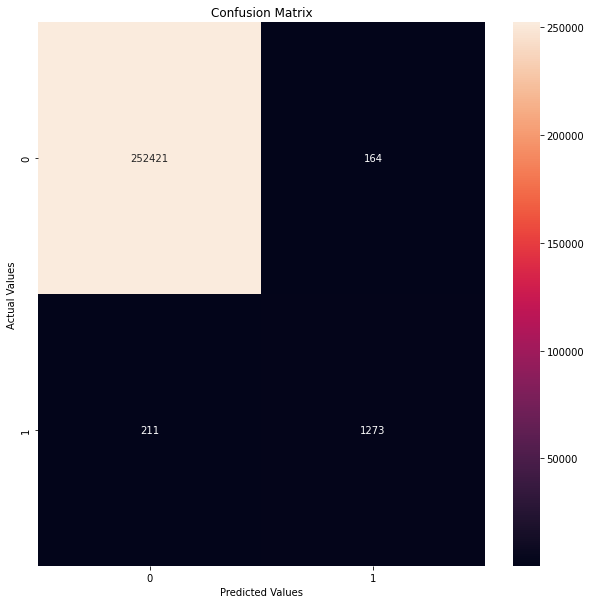

In [ ]:
evaluacion(modelo = DTclf_Y2, y_val_real = '6_hours')

**Commentarios** 

Al predecir la variable dependiente para una falla con 6 horas de anticipación, el Decision Tree también tuvo éxito con un recall de 0.858 y un precision de 0.886. Estos resultados son ligeramente mejores que los para el modelo de tres horas de anticipación. Esta mejora era esperable ya que la variable dependiente de seis horas está menos desequilibrada gracias al aumento del tiempo de anticipación de tres a seis horas. 

##### DT - 12 Horas de Anticipación

In [ ]:
# DT Classifier para 12 horas de anticipacion

In [ ]:
from sklearn.tree import DecisionTreeClassifier
DTclf_Y3 = DecisionTreeClassifier(random_state=123)
DTclf_Y3.fit(X_training, Y3)

DecisionTreeClassifier(random_state=123)

Resltados de DecisionTreeClassifier(random_state=123) con umbral de decision de 0.5

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    251313
           1       0.85      0.86      0.86      2756

    accuracy                           1.00    254069
   macro avg       0.92      0.93      0.93    254069
weighted avg       1.00      1.00      1.00    254069


Recall:  0.863933236574746

Precision:  0.850053552302749

F1:  0.8569371963289544

Accuracy:  0.9968709287634462

Confusion Matrix


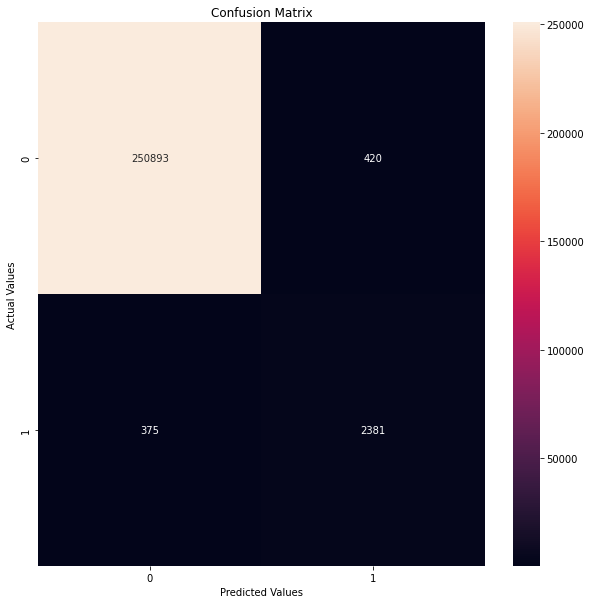

In [ ]:
evaluacion(modelo = DTclf_Y3, y_val_real = '12_hours')

**Commentarios**

Este modelo para predecir la variable dependiente con 12 horas de anticipación también funcionó bien con un ecall de 0.864. Sin embargo, a pesar de la reducción del desequilibrio en la variable dependiente, el modelo no tuvo un aumento en el rendimiento en comparación con el modelo de 6 horas de anticipación. 

#### 4.2) Random Forest


##### RF - Tres horas de Anticipación

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RFclf = RandomForestClassifier(random_state=123)

RFclf.fit(X_training, Y1)

RandomForestClassifier(random_state=123)

Resltados de RandomForestClassifier(random_state=123) con umbral de decision de 0.5

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    253134
           1       0.98      0.36      0.53       935

    accuracy                           1.00    254069
   macro avg       0.99      0.68      0.76    254069
weighted avg       1.00      1.00      1.00    254069


Recall:  0.3593582887700535

Precision:  0.9767441860465116

F1:  0.5254104769351056

Accuracy:  0.9976108852319645

Confusion Matrix


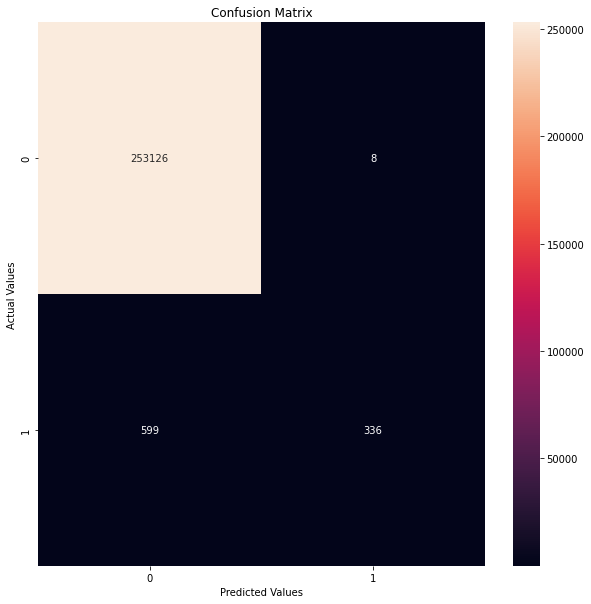

In [ ]:
evaluacion(RFclf, y_val_real = '3_hours')

##### RF - Sies horas de Anticipación

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RFclf_Y2 = RandomForestClassifier(random_state=123)

RFclf_Y2.fit(X_training, Y2)

RandomForestClassifier(random_state=123)

Resltados de RandomForestClassifier(random_state=123) con umbral de decision de 0.5

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    252435
           1       0.98      0.62      0.76      1634

    accuracy                           1.00    254069
   macro avg       0.99      0.81      0.88    254069
weighted avg       1.00      1.00      1.00    254069


Recall:  0.6230110159118727

Precision:  0.9845261121856866

F1:  0.7631184407796101

Accuracy:  0.9975124867654063

Confusion Matrix


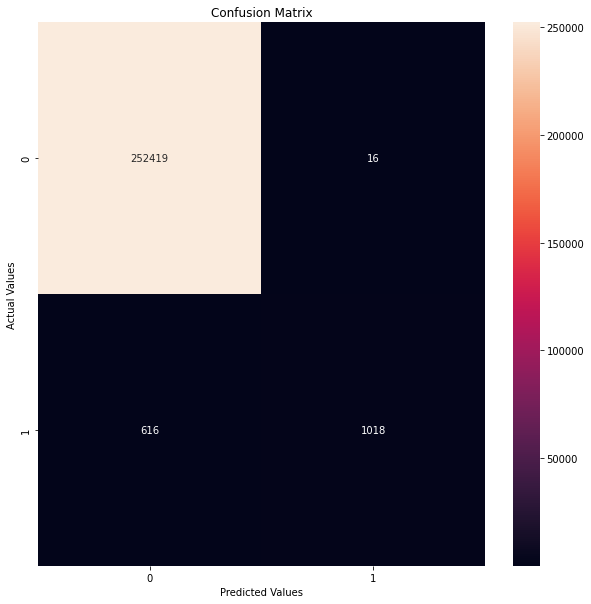

In [ ]:
evaluacion(RFclf_Y2, y_val_real = '6_hours')

##### RF - 12 horas de Anticipación

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RFclf_Y3 = RandomForestClassifier(random_state=123)

RFclf_Y3.fit(X_training, Y3)

RandomForestClassifier(random_state=123)

Resltados de RandomForestClassifier(random_state=123) con umbral de decision de 0.5

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    251037
           1       0.99      0.49      0.66      3032

    accuracy                           0.99    254069
   macro avg       0.99      0.75      0.83    254069
weighted avg       0.99      0.99      0.99    254069


Recall:  0.4904353562005277

Precision:  0.9913333333333333

F1:  0.6562224183583407

Accuracy:  0.9938678075640869

Confusion Matrix


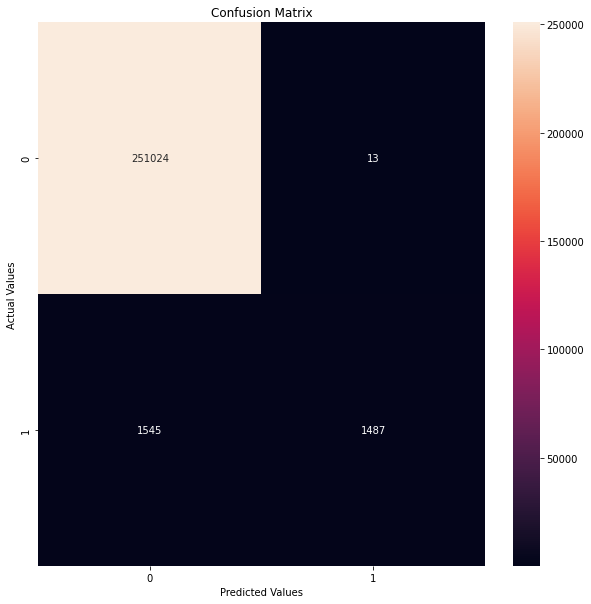

In [ ]:
evaluacion(RFclf_Y3, y_val_real = '12_hours')

**Commentarios** 

Para los tres modelos de Random Forest hay un patron parecido en que no tienen muchos falsos positivos, con buenos resultados para la metrica de precision de (RF-3 Horas: 0.977, RF-6 Horas: 0.984, RF-12 Horas: 0.99). Sin embargo, lo encuentran mas dificil, que los modelos de Decision Tree, classificar las fallas reales con resultados de Recall mas bajo (RF-3 Horas: 0.359, RF-6 Horas: 0.623, RF-12 Horas: 0.49). La reducción en el desequilibrio en la variable debendiente entre 3 y 6 horas de anticipación conllevó una reduccion en los falos negativos. 

Una opción ahora sería intentar encontrar la mejor combinación de parametros en los modelos de random forest ya que se ha visto que con los parametros predeterminados los modelos no reducen los falsos negativos tan bien. Sin embargo, en esta etapa de entrenamiento se desea minimizar el tiempo necesitado para entrenar los modelos. Por lo tanto, a continuación se entrenarán modelos de Bagging Decision Tree, ya que son mas rapidos para entrenar y al utilizar el concepto de bagging se espera reducir cualquier sobreajuste que podría haber occurrido con los modelos de Decison Tree. 

#### 4.3) Bagging - Decision Tree

Aqui se entrenan modelos de Bagging Decision Tree para los tres variables dependientes (3 horas, 6 horas, y 12 horas). Se utilizan los parámetros de: 

- max samples = 0.5
- max features = 1.0
- n_estimators = 10

Con la esperanza que el sobre ajuste se evite, pero tambien que los modelos no se demoren en entrenarse. 

##### Bagging - Tres Horas de Anticipación

In [ ]:
bg =BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=10)
bg.fit(X_training, Y1)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.5)

Resltados de BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.5) con umbral de decision de 0.5

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    253134
           1       0.96      0.87      0.91       935

    accuracy                           1.00    254069
   macro avg       0.98      0.94      0.96    254069
weighted avg       1.00      1.00      1.00    254069


Recall:  0.8705882352941177

Precision:  0.961038961038961

F1:  0.9135802469135802

Accuracy:  0.9993938654460008

Confusion Matrix


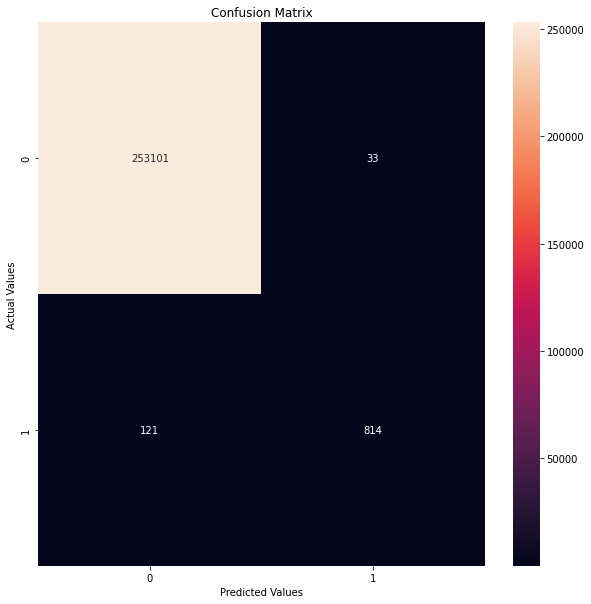

In [ ]:
evaluacion(bg, y_val_real = '3_hours')

##### Bagging - Seis Horas de Anticipación

In [ ]:
bg_Y2 =BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=10)
bg_Y2.fit(X_training, Y2)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.5)

Resltados de BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.5) con umbral de decision de 0.5

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    252435
           1       0.95      0.89      0.92      1634

    accuracy                           1.00    254069
   macro avg       0.98      0.94      0.96    254069
weighted avg       1.00      1.00      1.00    254069


Recall:  0.8898408812729498

Precision:  0.9534426229508197

F1:  0.9205444761000318

Accuracy:  0.9990120793957546

Confusion Matrix


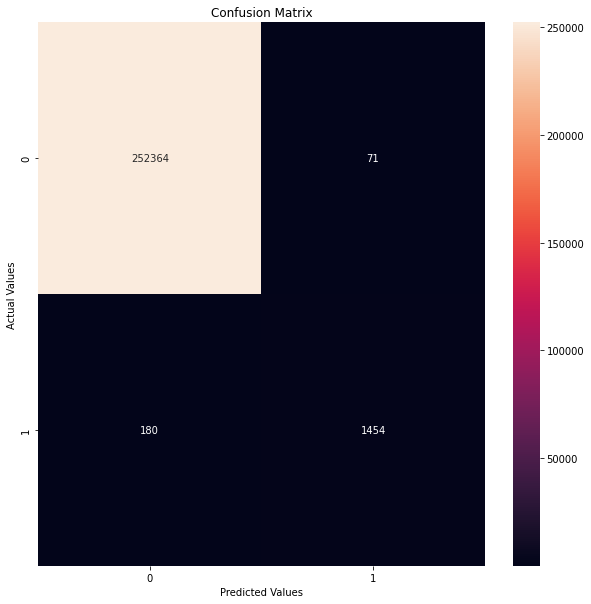

In [ ]:
evaluacion(bg_Y2, y_val_real = '6_hours')

##### Bagging - Doce Horas de Anticipación

In [ ]:
bg_Y3 =BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=10)
bg_Y3.fit(X_training, Y3)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.5)

Resltados de BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.5) con umbral de decision de 0.5

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    251037
           1       0.96      0.88      0.92      3032

    accuracy                           1.00    254069
   macro avg       0.98      0.94      0.96    254069
weighted avg       1.00      1.00      1.00    254069


Recall:  0.8763192612137203

Precision:  0.9592057761732852

F1:  0.9158910720441226

Accuracy:  0.9980792619327821

Confusion Matrix


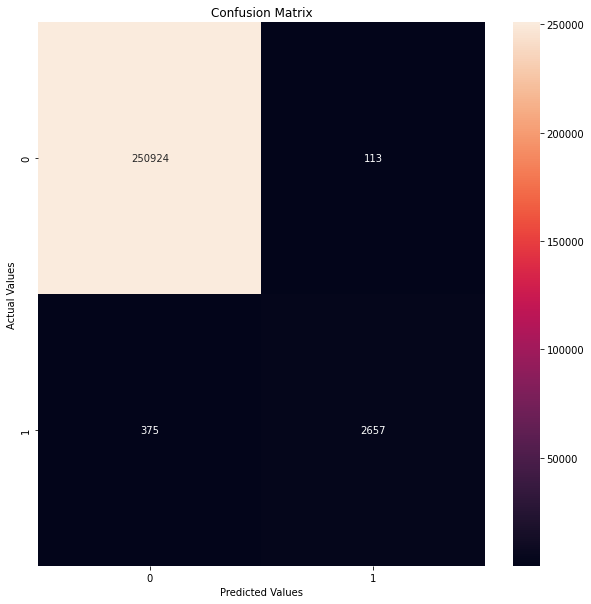

In [ ]:
evaluacion(bg_Y3, y_val_real = '12_hours')

**Commentarios**

En los modelos de Bagging - Decison Tree, el resultado de Recall se mejoró superando levemente los resultados de los Decision Tree, y por mucho resultados de los Random Forest (DTBag 3 Horas: 0.87, DTBag 6 Horas: 0.89 , DTBag 12 Horas: 0.88). 

En todos los modelos hasta ahora se ha predicho de manera mejor la variable dependiente de 6 horas cuando se toma recall y una reducción en falsos negativos como la metrica de evluación.  

A continuación se entrenará modelos de XGBoost ya que su umbral de decision se puede cambiar. Se modificará el umbral con la intención de maximizar el resultado de recall y reducir los falsos negativos. 

#### 4.4) XGBOOST

##### XGB - Tres Horas de Anticipación

In [ ]:
XGB = XGBClassifier(random_state = 123)
XGB.fit(X_training, Y1)

XGBClassifier(random_state=123)

Resltados de XGBClassifier(random_state=123) con umbral de decision de 0.5

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    253134
           1       0.98      0.77      0.86       935

    accuracy                           1.00    254069
   macro avg       0.99      0.89      0.93    254069
weighted avg       1.00      1.00      1.00    254069


Recall:  0.7732620320855615

Precision:  0.9757085020242915

F1:  0.8627684964200476

Accuracy:  0.9990947341076637

Confusion Matrix


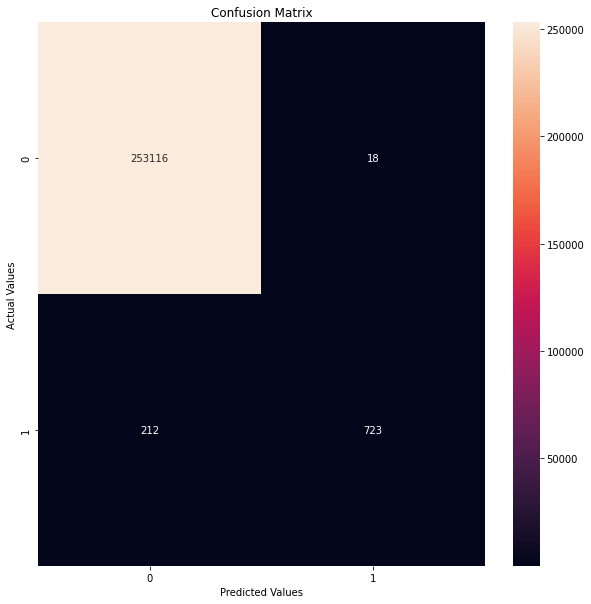

In [ ]:
evaluacion(XGB, y_val_real = '3_hours')

##### XGB - Seis Horas de Anticipación

In [ ]:
XGB_Y2 = XGBClassifier(random_state = 123)
XGB_Y2.fit(X_training, Y2)

XGBClassifier(random_state=123)

Resltados de XGBClassifier(random_state=123) con umbral de decision de 0.5

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    252435
           1       0.99      0.89      0.94      1634

    accuracy                           1.00    254069
   macro avg       0.99      0.94      0.97    254069
weighted avg       1.00      1.00      1.00    254069


Recall:  0.8898408812729498

Precision:  0.9864314789687924

F1:  0.9356499356499356

Accuracy:  0.9992128122675337

Confusion Matrix


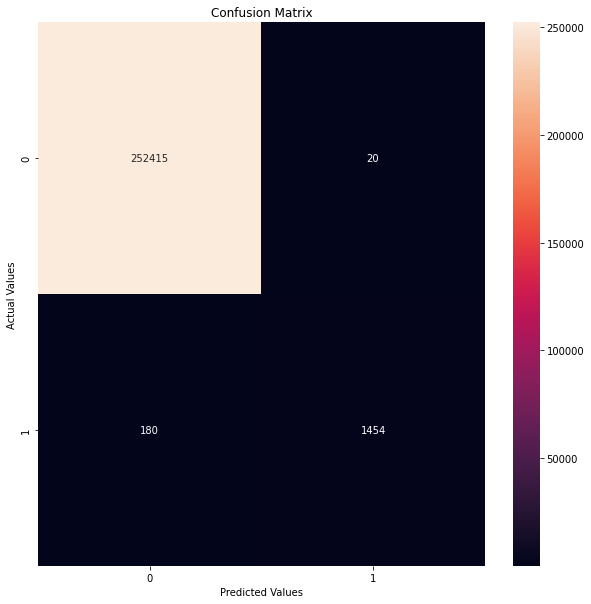

In [ ]:
evaluacion(XGB_Y2, y_val_real = '6_hours')

##### XGB - Doce Horas de Anticipación

In [ ]:
XGB_Y3 = XGBClassifier(random_state = 123)
XGB_Y3.fit(X_training, Y3)

XGBClassifier(random_state=123)

Resltados de XGBClassifier(random_state=123) con umbral de decision de 0.5

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    251037
           1       0.97      0.91      0.94      3032

    accuracy                           1.00    254069
   macro avg       0.99      0.95      0.97    254069
weighted avg       1.00      1.00      1.00    254069


Recall:  0.9076517150395779

Precision:  0.9745042492917847

F1:  0.9398907103825136

Accuracy:  0.9986145495908592

Confusion Matrix


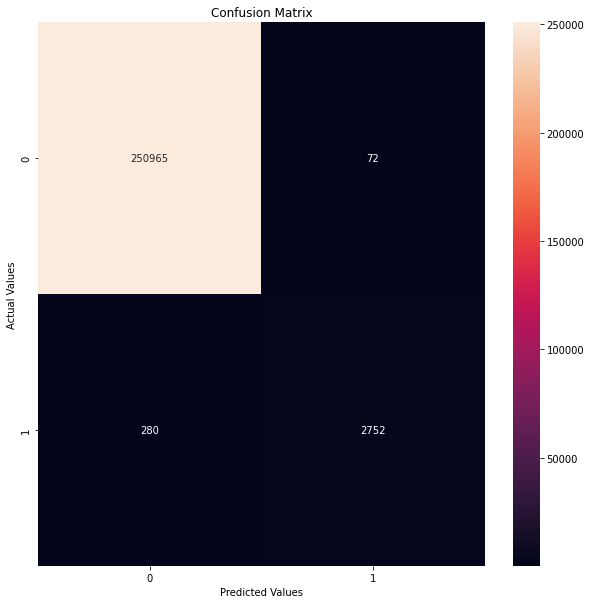

In [ ]:
evaluacion(XGB_Y3, y_val_real = '12_hours')

**Commentarios**

Los tres modelos de XGBoost tienen un buen rendimiento tras estar evaluados con los datos de validación. Sin embargo, se nota en los resultados que XGBoost reduce los falsos positivos de manera mejor para las variables dependientes de 6 horas (recall: 0.89) y 12 horas (recall: 0.91). Para 3 horas el recall es 0.77. Esta es la primera vez que un modelo ha tendio mejor rendimiento (en cuanto a recall) con la variable dependiente de 12 horas. Tambien se nota que los tres modelos de XGBoost no tienen muchos falsos positivos (precision XGB - 3horas: 0.98, XGB - 6horas: 0.99, XGB - 12horas: 0.97). Por lo tanto, a continuación se modificarán los umbrales de decision, que actualmente son 0.5 para priorizar la reducción en falsos negativos. 

#### 4.5) XGBoost - umbral de decision optimizado

In [ ]:
np.set_printoptions(precision=3)

Aquí se crea una función que calcula cual umbral de decision entre un rango de 0.1 y 1 da los mejores resultados para cada una de las metricas de recall, precision, y f1. Nos enfocaremos en como el umbral se puede modificar para maximizar el recall. 

In [ ]:
def umbral(modelo = None, Yval = None, metrica = None):
  y_val_real_ = validation[Yval]
  yhat = modelo.predict_proba(X_validation)
  probs = yhat[:, 1]
  Umbral = np.arange(0.1, 1, 0.1)
  def to_labels(pos_probs, Umbral):
    return (pos_probs >= Umbral).astype('int')
  scores = [metrica(y_val_real_, to_labels(probs, t)) for t in Umbral]
  ix = np.argmax(scores)
  print('Umbral=%.3f, Metric=%.5f' % (Umbral[ix], scores[ix]))

##### Umbral - XGBoost 3 Horas

In [ ]:
umbral(modelo = XGB, Yval='3_hours', metrica = recall_score)

Umbral=0.100, Metric=0.96578


In [ ]:
umbral(modelo = XGB, Yval='3_hours', metrica = precision_score)

Umbral=0.900, Metric=0.99387


In [ ]:
umbral(modelo = XGB, Yval='3_hours', metrica = f1_score)

Umbral=0.300, Metric=0.92826


##### Umbral - XGBoost 6 horas

In [ ]:
umbral(modelo = XGB_Y2, Yval='6_hours', metrica = recall_score)

Umbral=0.100, Metric=0.97246


In [ ]:
umbral(modelo = XGB_Y2, Yval='6_hours', metrica = precision_score)

Umbral=0.800, Metric=1.00000


In [ ]:
umbral(modelo = XGB_Y2, Yval='6_hours', metrica = f1_score)

Umbral=0.300, Metric=0.95847


##### Umbral XGBoost - 12 horas

In [ ]:
umbral(modelo = XGB_Y3, Yval='12_hours', metrica = recall_score)

Umbral=0.100, Metric=0.96900


In [ ]:
umbral(modelo = XGB_Y3, Yval='12_hours', metrica = precision_score)

Umbral=0.900, Metric=1.00000


In [ ]:
umbral(modelo = XGB_Y3, Yval='12_hours', metrica = f1_score)

Umbral=0.400, Metric=0.94883


El anailis de los umbrales exponen que para las tres varaibles dependientes (3 horas, 6 horas, y 12 horas) la metrica de recall se puede maximizar con un umbral de decision de 0.1. 

A continuación los tres modelos de XGBoost se evaluarán con los datos de evaluación de nuevo, pero esta vez utilizando un umbral de decision de 0.1. 

In [ ]:
def evaluacion2(modelo = None, umbral = 'Normal', y_val_real = None, nuevo_umbral = None):
  if umbral == 'Normal':
    print('Resltados de ' +str(modelo)+' con umbral de decision de ' +str(umbral))
    print()
    y_val_real_ = validation[y_val_real]
    y_val_pred = modelo.predict(X_validation)
    print(classification_report(y_val_real_, y_val_pred))
    print()
    print('Recall: ', recall_score(y_val_real_, y_val_pred, average='binary'))
    print()
    print('Precision: ', precision_score(y_val_real_, y_val_pred, average='binary'))
    print()
    print('F1: ',f1_score(y_val_real_, y_val_pred, average='binary'))
    print()
    print('Accuracy: ', accuracy_score(y_val_real_, y_val_pred))
    print()
    print('Confusion Matrix')
    plt.figure(figsize=(10,10))
    sns.heatmap(confusion_matrix(y_val_real_, y_val_pred), annot=True, fmt = 'g')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()
  elif umbral == 'cambio':
    print('Resultados de '+str(modelo)+' con umbral de decision de '+str(nuevo_umbral))
    print()
    y_val_real_ = validation[y_val_real]
    y_scores_val = modelo.predict_proba(X_validation)[:, 1]
    y_scores_val_df = pd.DataFrame(modelo.predict_proba(X_validation)[:, 1])
    y_scores_val_df = y_scores_val_df.rename(columns = {0: 'Prediction'})
    y_scores_val_df['decison_threshold'+str(nuevo_umbral)] = np.where(y_scores_val_df['Prediction'] >= nuevo_umbral, 1, 0)
    # Metricas de evaluacion
    print(classification_report(y_val_real_, y_scores_val_df['decison_threshold'+str(nuevo_umbral)]))
    print()
    print('Recall: ', recall_score(y_val_real_, y_scores_val_df['decison_threshold'+str(nuevo_umbral)], average='binary'))
    print()
    print('Precision: ', precision_score(y_val_real_, y_scores_val_df['decison_threshold'+str(nuevo_umbral)], average='binary'))
    print()
    print('F1: ',f1_score(y_val_real_, y_scores_val_df['decison_threshold'+str(nuevo_umbral)], average='binary'))
    print()
    print('Accuracy: ', accuracy_score(y_val_real_, y_scores_val_df['decison_threshold'+str(nuevo_umbral)]))
    print()
    print('Confusion Matrix')
    plt.figure(figsize=(10,10))
    sns.heatmap(confusion_matrix(y_val_real_, y_scores_val_df['decison_threshold'+str(nuevo_umbral)]), annot=True, fmt = 'g')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

##### XGBoost - 3 Horas - Umbral 0.1

Resultados de XGBClassifier(random_state=123) con umbral de decision de 0.1

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    253134
           1       0.76      0.97      0.85       935

    accuracy                           1.00    254069
   macro avg       0.88      0.98      0.93    254069
weighted avg       1.00      1.00      1.00    254069


Recall:  0.9657754010695188

Precision:  0.7639593908629442

F1:  0.8530940009447332

Accuracy:  0.9987759230760148

Confusion Matrix


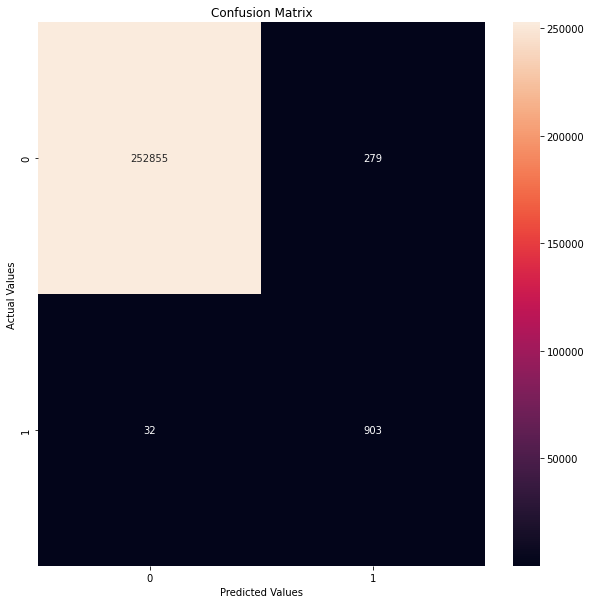

In [ ]:
evaluacion2(modelo = XGB, umbral = 'cambio', y_val_real = '3_hours', nuevo_umbral= 0.1)

##### XGBoost - 6 Horas - umbral 0.1

Resultados de XGBClassifier(random_state=123) con umbral de decision de 0.1

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    252435
           1       0.77      0.97      0.86      1634

    accuracy                           1.00    254069
   macro avg       0.89      0.99      0.93    254069
weighted avg       1.00      1.00      1.00    254069


Recall:  0.9724602203182374

Precision:  0.7743664717348928

F1:  0.86218122626153

Accuracy:  0.9980005431595353

Confusion Matrix


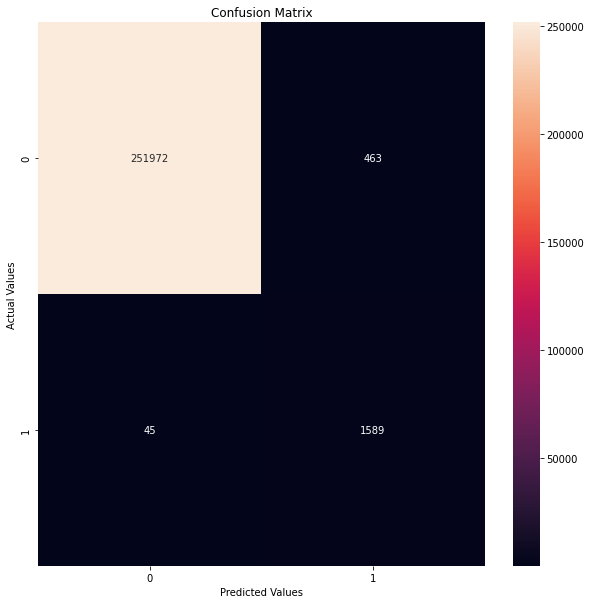

In [ ]:
evaluacion2(modelo = XGB_Y2, umbral = 'cambio', y_val_real = '6_hours', nuevo_umbral= 0.1)

##### XGBoost - 12 Horas - Umbral 0.1

Resultados de XGBClassifier(random_state=123) con umbral de decision de 0.1

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    251037
           1       0.76      0.97      0.85      3032

    accuracy                           1.00    254069
   macro avg       0.88      0.98      0.92    254069
weighted avg       1.00      1.00      1.00    254069


Recall:  0.9689973614775725

Precision:  0.7550758159856078

F1:  0.8487649862776252

Accuracy:  0.9958790722205385

Confusion Matrix


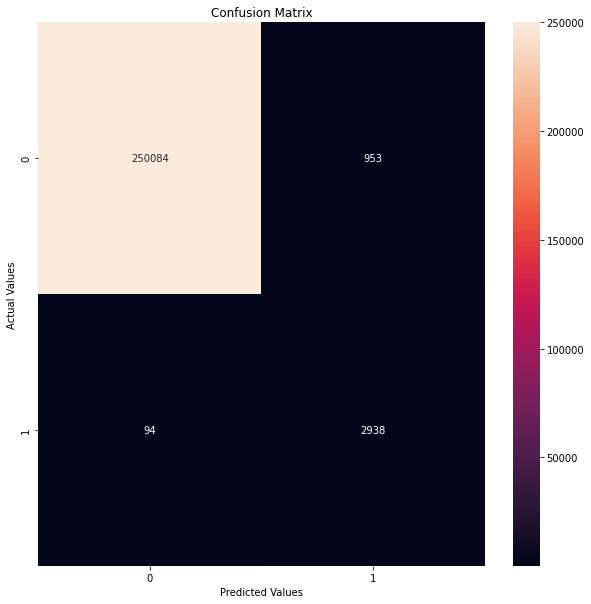

In [ ]:
evaluacion2(modelo = XGB_Y3, umbral = 'cambio', y_val_real = '12_hours', nuevo_umbral= 0.1)

Se han evaluado los 3 modelos de XGBoost con umbrales de decision de 0.1. Este umbral maximiza la metrica de recall y una reducción en falsos negativos. 

Con un umbral de decision de 0.1 el recall aumenta a 0.97 para los tres modelos. Por supuesto al cambiar el umbral de decision a 0.1 hay un aumento en los falsos positivos con la metrica de precision empeorando (precision: XGB 3 Horas Umrbal 0.1: 0.77, XGB 6 Horas Umrbal 0.1: 0.77, XGB 12 Horas Umbral 0.1: 0.76). 

Estos modelos con la minima cantidad de falsos negativos se utilizarán como el modelo final ya que una falla no detectada (falso negativo) de las maquinas es mucho mas costa para el cliente que una mantención adicional que se realiza cuando un falso positivo se predice. 

#### 4.6) Feature Importance

Los gráficos a continuación identifican las variables de mayor impotancia en los tres modelos de XGBoost. Las variables de la hora, y la media en las ultimas doce horas para voltaje tienen mas importancia en los tres modelos. 

Text(0.5, 1.0, 'Feature Importance - Modelo XGBoost')

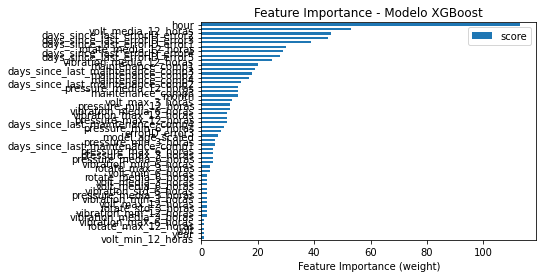

In [ ]:
feature_important = XGB.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)

data.plot(kind='barh')

plt.xlabel("Feature Importance (weight)")

plt.title('Feature Importance - Modelo XGBoost')

Text(0.5, 1.0, 'Feature Importance - Modelo XGBoost')

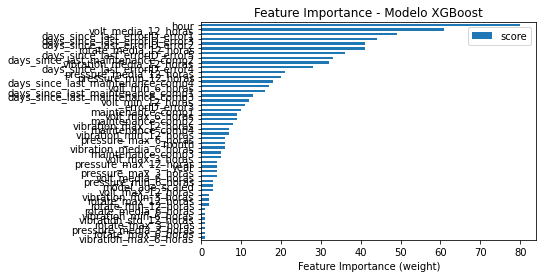

In [ ]:
feature_important = XGB_Y2.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)

data.plot(kind='barh')

plt.xlabel("Feature Importance (weight)")

plt.title('Feature Importance - Modelo XGBoost')

Text(0.5, 1.0, 'Feature Importance - Modelo XGBoost')

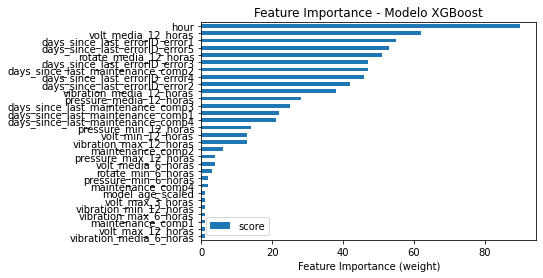

In [ ]:
feature_important = XGB_Y3.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)

data.plot(kind='barh')

plt.xlabel("Feature Importance (weight)")

plt.title('Feature Importance - Modelo XGBoost')

### 5) Datos de Test

Tras elegir los modelos de XGBoost con el umbral de decision optimizado a 0.1 como los modelos finales, serán probados con los datos de test. 

La función creada a continuación se usa para probar los modelos con los datos de test. 

In [ ]:
def evaluacion_test(modelo = None, umbral = 'Normal', y_val_real = None, nuevo_umbral = None):
  if umbral == 'Normal':
    print('Resltados de ' +str(modelo)+' con umbral de decision de ' +str(umbral))
    print()
    y_val_real_ = validation[y_val_real]
    y_val_pred = modelo.predict(X_validation)
    print(classification_report(y_val_real_, y_val_pred))
    print()
    print('Recall: ', recall_score(y_val_real_, y_val_pred, average='binary'))
    print()
    print('Precision: ', precision_score(y_val_real_, y_val_pred, average='binary'))
    print()
    print('F1: ',f1_score(y_val_real_, y_val_pred, average='binary'))
    print()
    print('Accuracy: ', accuracy_score(y_val_real_, y_val_pred))
    print()
    print('Confusion Matrix')
    plt.figure(figsize=(10,10))
    sns.heatmap(confusion_matrix(y_val_real_, y_val_pred), annot=True, fmt = 'g')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()
  elif umbral == 'cambio':
    print('Resultados de test con'+str(modelo)+' con umbral de decision de '+str(nuevo_umbral))
    print()
    y_val_real_ = testing[y_val_real]
    y_scores_val = modelo.predict_proba(X_testing)[:, 1]
    y_scores_val_df = pd.DataFrame(modelo.predict_proba(X_testing)[:, 1])
    y_scores_val_df = y_scores_val_df.rename(columns = {0: 'Prediction'})
    y_scores_val_df['decison_threshold'+str(nuevo_umbral)] = np.where(y_scores_val_df['Prediction'] >= nuevo_umbral, 1, 0)
    # Metricas de evaluacion
    print(classification_report(y_val_real_, y_scores_val_df['decison_threshold'+str(nuevo_umbral)]))
    print()
    print('Recall: ', recall_score(y_val_real_, y_scores_val_df['decison_threshold'+str(nuevo_umbral)], average='binary'))
    print()
    print('Precision: ', precision_score(y_val_real_, y_scores_val_df['decison_threshold'+str(nuevo_umbral)], average='binary'))
    print()
    print('F1: ',f1_score(y_val_real_, y_scores_val_df['decison_threshold'+str(nuevo_umbral)], average='binary'))
    print()
    print('Accuracy: ', accuracy_score(y_val_real_, y_scores_val_df['decison_threshold'+str(nuevo_umbral)]))
    print()
    print('Confusion Matrix')
    plt.figure(figsize=(10,10))
    sns.heatmap(confusion_matrix(y_val_real_, y_scores_val_df['decison_threshold'+str(nuevo_umbral)]), annot=True, fmt = 'g')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

Resultados de test conXGBClassifier(random_state=123) con umbral de decision de 0.1

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    244616
           1       0.69      0.96      0.80       692

    accuracy                           1.00    245308
   macro avg       0.84      0.98      0.90    245308
weighted avg       1.00      1.00      1.00    245308


Recall:  0.958092485549133

Precision:  0.6863354037267081

F1:  0.7997587454764777

Accuracy:  0.9986465993771096

Confusion Matrix


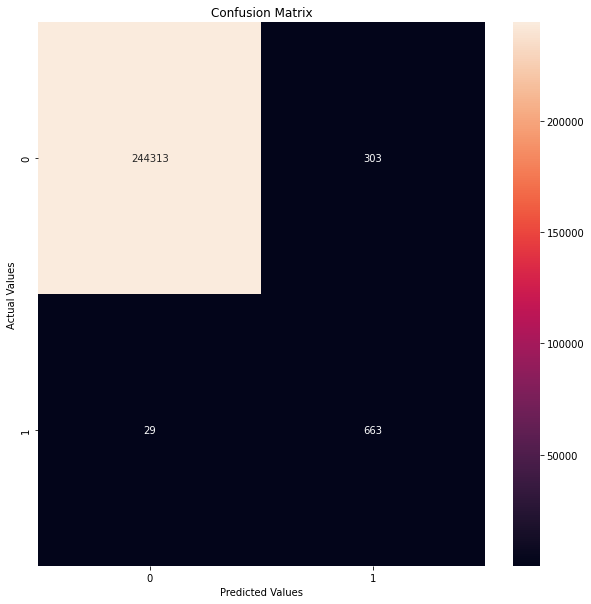

In [ ]:
evaluacion_test(modelo = XGB, umbral = 'cambio', y_val_real = '3_hours', nuevo_umbral= 0.1)

Resultados de test conXGBClassifier(random_state=123) con umbral de decision de 0.1

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    244097
           1       0.72      0.96      0.82      1211

    accuracy                           1.00    245308
   macro avg       0.86      0.98      0.91    245308
weighted avg       1.00      1.00      1.00    245308


Recall:  0.9628406275805119

Precision:  0.7153374233128834

F1:  0.8208377331925379

Accuracy:  0.9979250574787614

Confusion Matrix


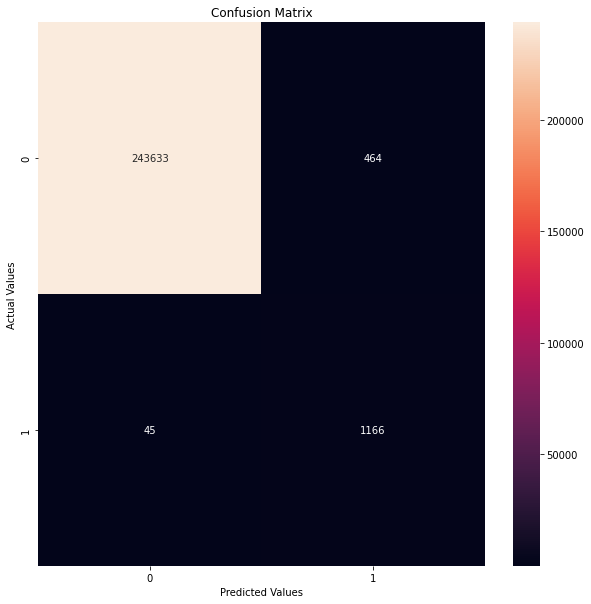

In [ ]:
evaluacion_test(modelo = XGB_Y2, umbral = 'cambio', y_val_real = '6_hours', nuevo_umbral= 0.1)

Resultados de test conXGBClassifier(random_state=123) con umbral de decision de 0.1

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    243059
           1       0.73      0.96      0.83      2249

    accuracy                           1.00    245308
   macro avg       0.86      0.98      0.91    245308
weighted avg       1.00      1.00      1.00    245308


Recall:  0.9604268563806136

Precision:  0.7258064516129032

F1:  0.8267942583732057

Accuracy:  0.9963107603502536

Confusion Matrix


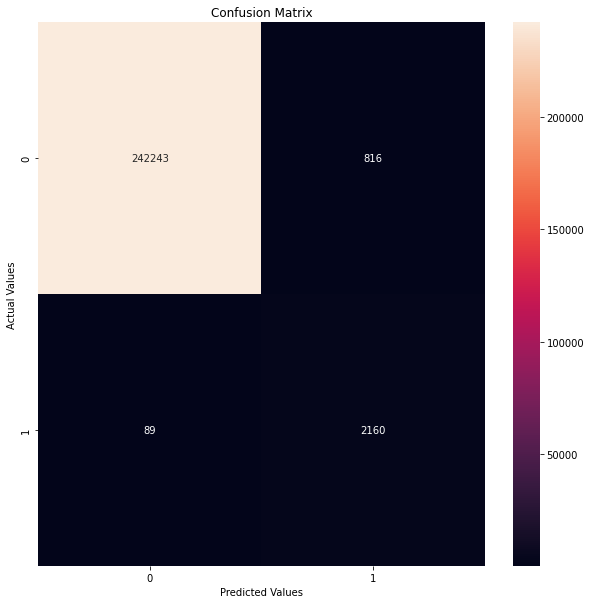

In [ ]:
evaluacion_test(modelo = XGB_Y3, umbral = 'cambio', y_val_real = '12_hours', nuevo_umbral= 0.1)

Tras probar los 3 modelos de XGBoost con el umbral de decision de 0.1 se confirma que los modelos tienen un buen rendimiento en cuanto a su habilidad de reducir la cantidad de falsos positivos. Los tres modelos tienen un recall de 0.96 con los datos de test.

In [ ]:
def evaluacion2(modelo = None, umbral = 'Normal', y_val_real = None, nuevo_umbral = None):
  if umbral == 'Normal':
    print('Resltados de ' +str(modelo)+' con umbral de decision de ' +str(umbral))
    print()
    y_val_real_ = validation[y_val_real]
    y_val_pred = modelo.predict(X_validation)
    print(classification_report(y_val_real_, y_val_pred))
    print()
    print('Recall: ', recall_score(y_val_real_, y_val_pred, average='binary'))
    print()
    print('Precision: ', precision_score(y_val_real_, y_val_pred, average='binary'))
    print()
    print('F1: ',f1_score(y_val_real_, y_val_pred, average='binary'))
    print()
    print('Accuracy: ', accuracy_score(y_val_real_, y_val_pred))
    print()
    print('Confusion Matrix')
    plt.figure(figsize=(10,10))
    sns.heatmap(confusion_matrix(y_val_real_, y_val_pred), annot=True, fmt = 'g')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()
  elif umbral == 'cambio':
    print('Resultados de '+str(modelo)+' con umbral de decision de '+str(nuevo_umbral))
    print()
    y_val_real_ = validation[y_val_real]
    y_scores_val = modelo.predict_proba(X_validation)[:, 1]
    y_scores_val_df = pd.DataFrame(modelo.predict_proba(X_validation)[:, 1])
    y_scores_val_df = y_scores_val_df.rename(columns = {0: 'Prediction'})
    y_scores_val_df['decison_threshold'+str(nuevo_umbral)] = np.where(y_scores_val_df['Prediction'] >= nuevo_umbral, 1, 0)
    # Metricas de evaluacion
    print(classification_report(y_val_real_, y_scores_val_df['decison_threshold'+str(nuevo_umbral)]))
    print()
    print('Recall: ', recall_score(y_val_real_, y_scores_val_df['decison_threshold'+str(nuevo_umbral)], average='binary'))
    print()
    print('Precision: ', precision_score(y_val_real_, y_scores_val_df['decison_threshold'+str(nuevo_umbral)], average='binary'))
    print()
    print('F1: ',f1_score(y_val_real_, y_scores_val_df['decison_threshold'+str(nuevo_umbral)], average='binary'))
    print()
    print('Accuracy: ', accuracy_score(y_val_real_, y_scores_val_df['decison_threshold'+str(nuevo_umbral)]))
    print()
    print('Confusion Matrix')
    plt.figure(figsize=(10,10))
    sns.heatmap(confusion_matrix(y_val_real_, y_scores_val_df['decison_threshold'+str(nuevo_umbral)]), annot=True, fmt = 'g')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

### 6) Evaluación del Proyecto

El **objectivo** de este proyecto era: 

*Crear un modelo de clasificación binaria que prediga si una máquina fallará con un período de anticipación de 3, 6, o 12 horas. Se probarán diferentes modelos de clasificación y períodos de anticipación para intentar maximizar el poder predictivo del modelo.* 

El proyecto tenían los siguientes **preguntas de valor**: 

1. ¿Se puede usar el mantenimiento predictivo para 
predecir con 3, 6 y 12 horas de anticipación si una máquina fallará? 

2. ¿Se requieren modelos separados de aprendizaje automático para hacer predicciones en los cuatro tipos diferentes de máquinas que se utilizan en la fábrica?

3. ¿Qué tipo de modelo de clasificación predice mejor las fallas de la máquina? 

4. ¿Qué variables se pueden crear con la ingeniería de funciones para mejorar el rendimiento del modelo? 

5. ¿Qué período de anticipación predice mejor las fallas de la máquina? 






#### 6.1) Evaluación de preguntas de valor

##### 6.1.1) ¿Se puede usar el mantenimiento predictivo para predecir con 3, 6 y 12 horas de anticipación si una máquina fallará? 


Se ha determinado que sí, mantenimiento predictivo se puede usar para predecr con 3, 6, y 12 horas de anticipación que una maquina fallará. 

Se crearon cuatro tipos de modelos, todos de los cuales tuvieron cierto grado de exito en cuanto a la predicción de fallas.

##### 6.1.2) ¿Se requieren modelos separados de aprendizaje automático para hacer predicciones en los cuatro tipos diferentes de máquinas que se utilizan en la fábrica?

Para responder a esta pregunta con mas certeza se requiere mas analisis. Sin embargo, el buen rendimiento de los modelos sin tomar en cuenta el modelo de la maquina sugiere que no es una variable muy importante. 

En futuro trabajo se podrían entranar modelos de XGBoost para cada unp de los cuatro modelos de las maquinas. Estos modelos se podrían evaluar con los resultados comparados con los resultados ya obtenidos. Tambien un T - Student test se podría usar para verificar si entre los cuatro modelos de maquinas existiera una diferencia significativa en cuanto a las variables de voltaje, rotación, presión, y vibración. Este test habría dado mas claridad en cuanto a la pregunta de valor 2. 

##### 6.1.3) ¿Qué tipo de modelo de clasificación predice mejor las fallas de la máquina? 

Se averiguó que los modelos de XGBoost con el umbral de decision de 0.1 mejor predijeron si una maquina iba a fallar desde el punto de vista de una reducción en falsos negativos. 

##### 6.1.4) ¿Qué variables se pueden crear con la ingeniería de funciones para mejorar el rendimiento del modelo? 

En la etapa del preprocesamiento de los datos varias nuevas variables se crearon con la ingenería de funciones. 

Se crearon variables para: 

- el promedio, valor minimo, valor maximo, y desviación estander, para los ultimos 3, 6, 12 horas para las configuraciones de  voltaje, rotación, presión, vibración de las maquinas. 

- la cantidad de dias desde el ultimo error de tipo 1, 2, 3, 4, y 5. 

- la cantidad de dias desde el ultimo mantimiento de componente 1, 2, 3, y 4. 

- el año, mes, dia de la semana, hora.  

Tras un analisis de la importancia de variables, se identificó que varias de las variables creadas tenían importancía en los modelos de XGBoost. La variable de hora, y la media para voltaje en las ultimas doce horas tenían mas importancia en los tres modelos de XGBoost. 

##### 6.1.5) ¿Qué período de anticipación predice mejor las fallas de la máquina? 

Tras entrenar modelos para predecir fallas con periodos de anticipación de 3, 6, y 12 horas se ha descubierto que el periodo de anticipación de 6 horas mejor predice una falla. Este periodo tiene la mejor reduccion en falsos negativos que se querian minimizar. El peor periodo para identificar fallas era 3 horas de anticipación, pero de todas formas tambien estuvo exitoso. La base de datos a continuación expone las metricas de precision y recall para todos los modelos. 

In [ ]:
pd.DataFrame(np.array([['3_hours', 'recall', 0.84, 0.359, 0.87, 0.77, 0.97],
                      ['3_hours', 'precision', 0.86, 0.977, 0.96, 0.98, 0.76],
                      ['6_hours', 'recall', 0.86, 0.623, 0.89, 0.89, 0.97],
                      ['6_hours', 'precision', 0.89, 0.984, 0.95, 0.99, 0.77], 
                      ['12_hours', 'recall', 0.86, 0.49, 0.88, 0.91, 0.97],
                      ['12_hours', 'precision', 0.85, 0.99, 0.96, 0.97, 0.76]]),
                      columns = ['periodo_anticipación', 'metrica', 'DecisionTree', 
                                 'RandomForest','BaggingDecisionTree', 'XGBoost', 'XGBoostUmbral0.1'])

,periodo_anticipación,metrica,DecisionTree,RandomForest,BaggingDecisionTree,XGBoost,XGBoostUmbral0.1
0,3_hours,recall,0.84,0.359,0.87,0.77,0.97
1,3_hours,precision,0.86,0.977,0.96,0.98,0.76
2,6_hours,recall,0.86,0.623,0.89,0.89,0.97
3,6_hours,precision,0.89,0.984,0.95,0.99,0.77
4,12_hours,recall,0.86,0.49,0.88,0.91,0.97
5,12_hours,precision,0.85,0.99,0.96,0.97,0.76


#### 6.2) Revision del proceso

Siento que el proyecto fue un exito ya que se desarrolló un modelo que logró un recall de 0.96 al estar probado con los datos de test. 

Sin embargo, y no solo hablando de este proyecto me gustaría mejorar mis conocimientos de cuando es mejor aplicar tecnicas como escalamiento de variables, y como se puede usar pruebas estadisitcas para verificar si hay una diferencia estadisiticamente significativo entre categorias de una variable. 

En cuanto a este proyecto me gustaría haber utilizado un T - Student test para verificar si entre los cuatro modelos de maquinas existiera una diferencia significativa en cuanto a las variables de voltaje, rotación, presión, y vibración. Este test habría dado mas claridad en cuanto a la pregunta de valor 2. 

Tambien me gustaría conseguir mas conocemiento de como las hyperparametros de los modelos se pueden ajustar y que hace exatamente cada hyperparametro. 

Un obstaculo al principio del proyecto era una falta de concomiento del rubro, y por tanto no sabía cual variables nuevas crear con los datos originales. Sin embago, suparé este problema tras investigar mas sobre las diferentes variables que se podrian crear con lectura de otros proyectos de mantenimiento predictivo de gran ayuda. Estas neuvas variables creadas con ingeneria de funciones ayudaron mucho en la predicción de las variables dependientes. 

#### 6.3) Proximas etapas

El modelo final elegido es XGBoost con un umbral de decision de 0.1. Tras probar estos modelos con los datos de test para las variables dependientes de 3 horas, 6 horas, y 12 horas se ha concluido que tienen un muy buen rendimiento con un recall de 0.96. Por lo tanto, se considera que estos tres modelos se podrían llevar a una etapa de produccion y dar predicciones sobre nuevos datos. Por supuesto, al recibir nueva informacion los modelos tendrían que estar re-entrenados constantemente. Para lograr este ciclo continuo de prediccion, re-entrenamiento, re-evaluacion, y prediccion se tendria que trabajar en conjunto con el equipo de Ingenieros de datos para utilizar el concepto de MLOps para crear una linea de trabajo parecido a ella mostrada en este [imagen](https://cloud.google.com/architecture/images/mlops-continuous-delivery-and-automation-pipelines-in-machine-learning-3-ml-automation-ct.svg).